#### Import

In [29]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import *
from netCDF4 import *
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import scipy.stats as stats

#### Exercise 1


In [2]:
data=xr.open_dataset("sst.nc")

def calculate_nino34(data):    
    sst_nino34=data.sst.sel(lat=slice(-5,5),lon=slice(190,240))
    tmp=sst_nino34.groupby('time.month')
    tmp1=tmp-tmp.mean(dim="time")
    index_nino34=tmp1.mean(dim=["lat","lon"])

    return index_nino34

index_nino34 = calculate_nino34(data)

([<matplotlib.axis.XTick at 0x776d9dff2060>,
 [Text(-21, 0, '1980'),
  Text(39, 0, '1985'),
  Text(99, 0, '1990'),
  Text(159, 0, '1995'),
  Text(219, 0, '2000'),
  Text(279, 0, '2005'),
  Text(339, 0, '2010'),
  Text(399, 0, '2015'),
  Text(459, 0, '2020'),
  Text(519, 0, '2025')])

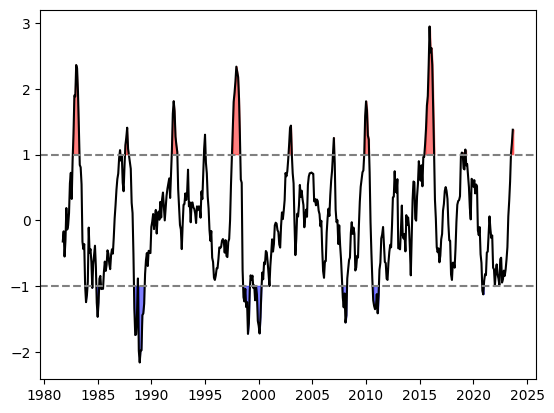

In [3]:
plt.plot(index_nino34, 'k')
# Draw the dashed horizontal line at y=1 and y=-1
plt.axhline(y=1, color='gray', linestyle='--')
plt.axhline(y=-1, color='gray', linestyle='--')
# Fill color
plt.fill_between(np.linspace(0,504,504),index_nino34, 1, where=(index_nino34 > 1), color='red', alpha=0.5)
plt.fill_between(np.linspace(0,504,504),index_nino34, -1, where=(index_nino34 < -1), color='blue', alpha=0.5)

# Year | start at sep 1981 and end at august 2023
x_ticks = np.arange(-21, 520, 5*12)
plt.xticks(x_ticks, [f"{1980 + i}" for i in range(0,46,5)])


#### Exercise 2

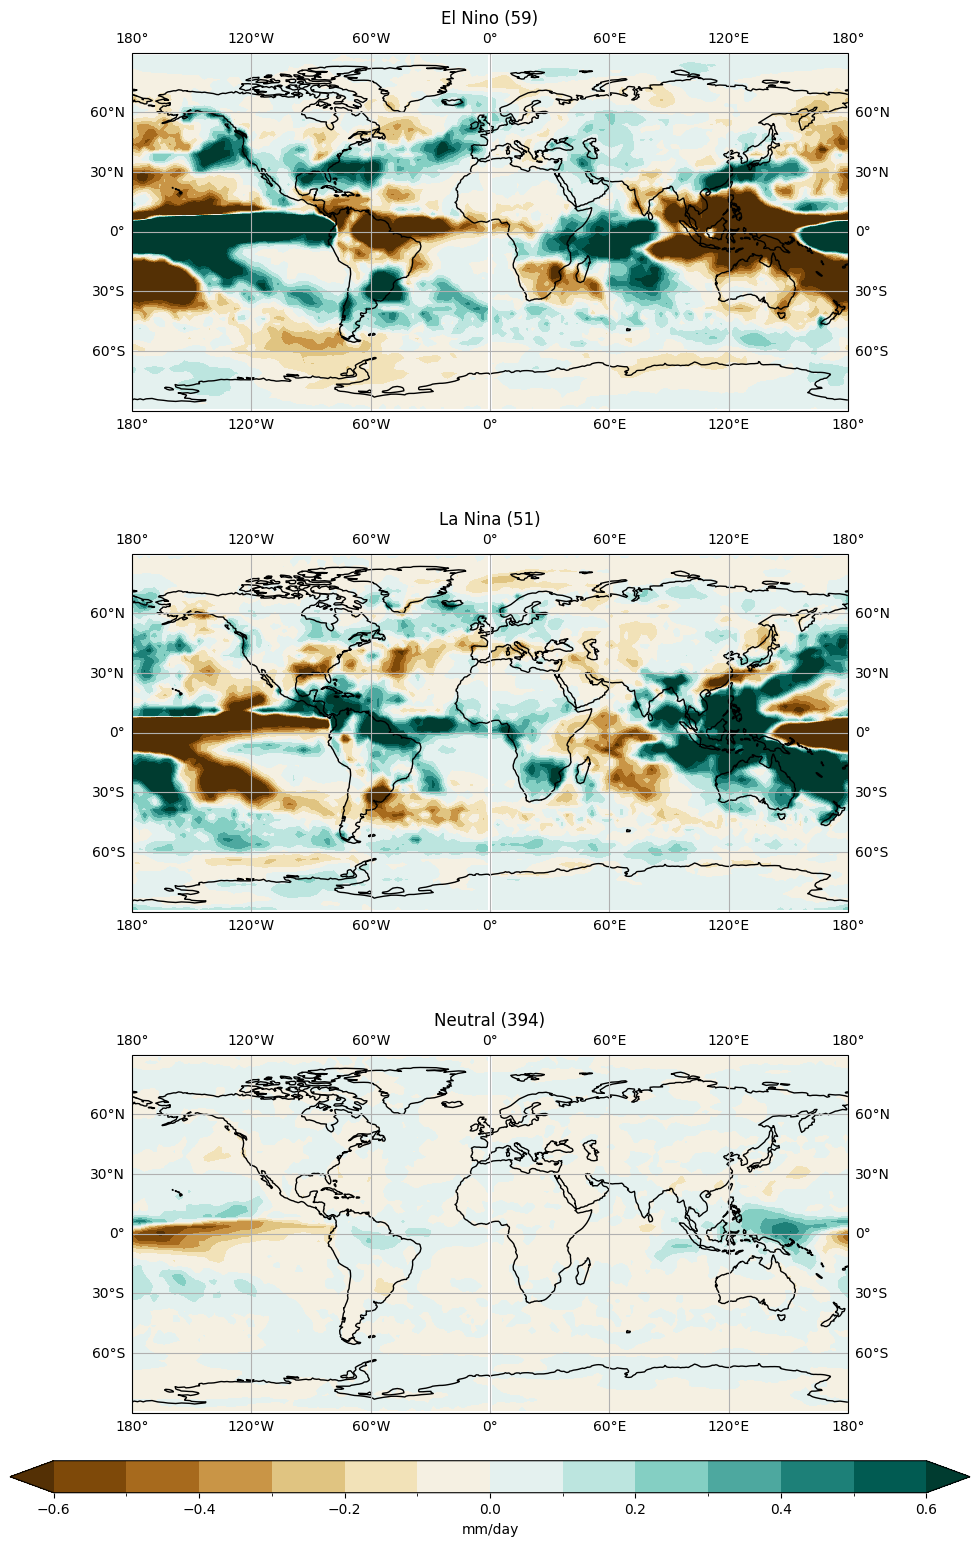

In [4]:
def classify_enso(nino34):
    """Classify months into El Niño, La Niña, or Neutral based on Nino3.4 index."""
    enso_state = xr.full_like(nino34, 'neutral', dtype='object')
    enso_state = xr.where(nino34 >= 1.0, 'elnino', enso_state)
    enso_state = xr.where(nino34 <= -1.0, 'lanina', enso_state)
    return enso_state

def calculate_enso_composites(precip_anomaly, enso_state):
    """Calculate precipitation anomaly composites for each ENSO phase."""
    elnino_comp = precip_anomaly.where(enso_state == 'elnino').mean('time')
    lanina_comp = precip_anomaly.where(enso_state == 'lanina').mean('time')
    neutral_comp = precip_anomaly.where(enso_state == 'neutral').mean('time')

    n_elnino = (enso_state == 'elnino').sum().values
    n_lanina = (enso_state == 'lanina').sum().values
    n_neutral = (enso_state == 'neutral').sum().values

    return elnino_comp, lanina_comp, neutral_comp, n_elnino, n_lanina, n_neutral

def plot_enso_composites(elnino_comp, lanina_comp, neutral_comp, n_elnino, n_lanina, n_neutral):
    """Create three-panel plot of ENSO precipitation anomaly composites."""
    fig = plt.figure(figsize=(12, 16))
    projection = ccrs.PlateCarree()

    vmin, vmax = -0.6, 0.6
    titles = [f'El Nino ({n_elnino})', f'La Nina ({n_lanina})', f'Neutral ({n_neutral})']
    composites = [elnino_comp, lanina_comp, neutral_comp]

    for idx, (title, data) in enumerate(zip(titles, composites)):
        ax = plt.subplot(3, 1, idx + 1, projection=projection)

        im = data.plot.contourf(
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=np.linspace(vmin, vmax, 13),
            cmap='BrBG',
            add_colorbar=False,
            extend='both'
        )

        ax.coastlines()
        ax.gridlines(draw_labels=True)

        ax.set_title(title)
        ax.set_ylim(-90, 90)
        ax.set_xlim(-180, 180)

    # Adjust colorbar position
    cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
    cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('mm/day', fontsize=10)

    # Adjust spacing
    plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.1, hspace=0.4)
    
    return plt

# Main execution
try:
    precip_ds = xr.open_dataset('precipe.nc')
    sst_ds = xr.open_dataset('sst.nc')

    climatology_sst = sst_ds['sst'].sel(time=slice('1981', '2024')).groupby('time.month').mean('time')
    anomalies_sst = sst_ds['sst'].groupby('time.month') - climatology_sst

    nino34 = index_nino34  # Using function from previous example

    precip = precip_ds['precip']
    if 'units' in precip.attrs and precip.attrs['units'] == 'mm/s':
        precip = precip * 86400

    climatology_precip = precip.sel(time=slice('1981', '2024')).groupby('time.month').mean('time')
    anomalies_precip = precip.groupby('time.month') - climatology_precip

    enso_state = classify_enso(nino34)

    elnino_comp, lanina_comp, neutral_comp, n_elnino, n_lanina, n_neutral = calculate_enso_composites(
        anomalies_precip, enso_state)

    plot_enso_composites(elnino_comp, lanina_comp, neutral_comp, n_elnino, n_lanina, n_neutral)
    plt.show()
except FileNotFoundError:
    print("Please ensure both 'precip.mon.mean.nc' and 'sst.nc' files are in the current directory")
except Exception as e:
    print(f"An error occurred: {str(e)}")

#### Homework

##### Exercise 3

In [5]:
elnino_vs_neural = elnino_comp - neutral_comp
lanina_vs_neural = lanina_comp - neutral_comp

<function matplotlib.pyplot.show(close=None, block=None)>

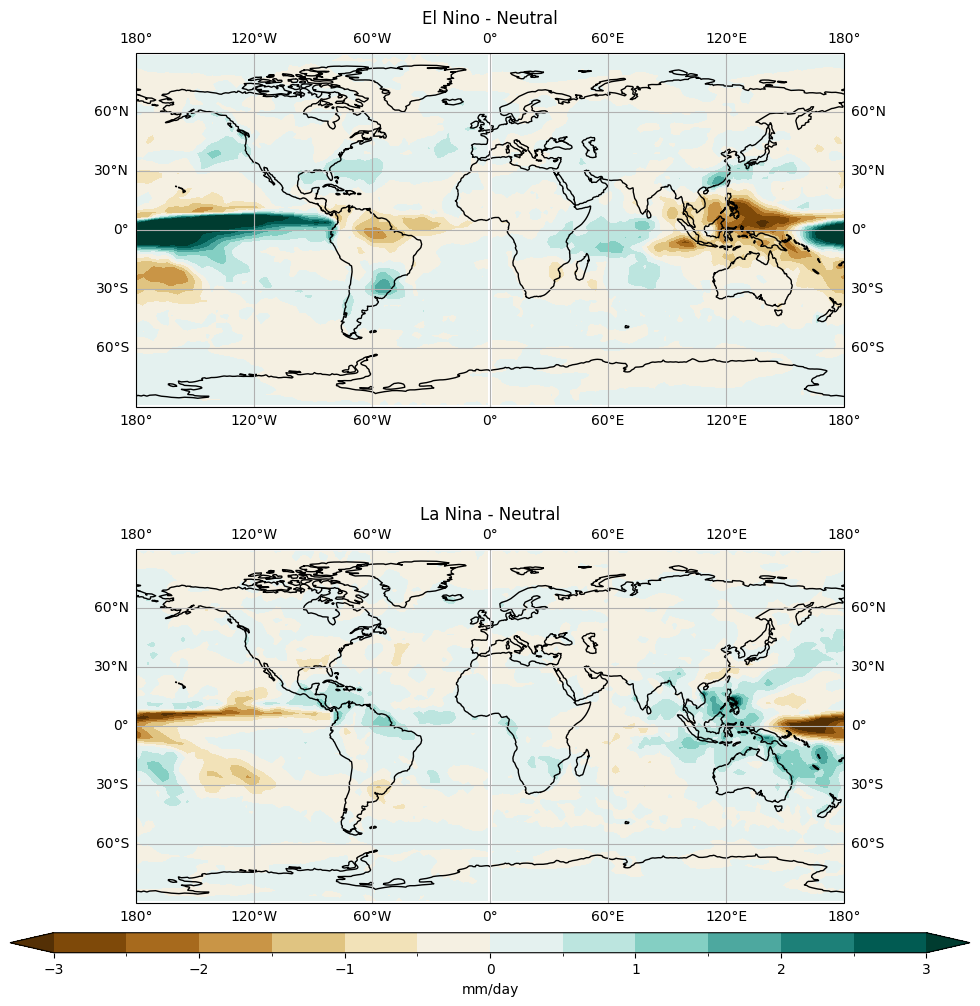

In [6]:
fig = plt.figure(figsize=(12, 10))
projection = ccrs.PlateCarree()

vmin, vmax = -3, 3
titles = [f'El Nino - Neutral', f'La Nina - Neutral']
composites = [elnino_vs_neural, lanina_vs_neural]

for idx, (title, data) in enumerate(zip(titles, composites)):
    ax = plt.subplot(2, 1, idx + 1, projection=projection)

    im = data.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=np.linspace(vmin, vmax, 13),
        cmap='BrBG',
        add_colorbar=False,
        extend='both'
    )

    ax.coastlines()
    ax.gridlines(draw_labels=True)

    ax.set_title(title)
    ax.set_ylim(-90, 90)
    ax.set_xlim(-180, 180)

# Adjust colorbar position
cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('mm/day', fontsize=10)

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.1, hspace=0.4)
plt.show

##### Exercise 4

In [9]:
def calculate_enso_composites2(precip_anomaly, enso_state):
    """Calculate precipitation anomaly composites for each ENSO phase."""
    elnino_comp = precip_anomaly.where(enso_state == 'elnino').to_numpy()
    lanina_comp = precip_anomaly.where(enso_state == 'lanina').to_numpy()
    neutral_comp = precip_anomaly.where(enso_state == 'neutral').to_numpy()

    return elnino_comp, lanina_comp, neutral_comp
    

In [10]:
# elnino_comp, lanina_comp, neutral_comp, n_elnino, n_lanina, n_neutral = calculate_enso_composites(anomalies_precip, enso_state)
elnino_comp, lanina_comp, neutral_comp = calculate_enso_composites2(anomalies_precip, enso_state)

In [15]:
def drop_nan_time(array):
    non_nan_mask = ~np.isnan(array).any(axis=(1,2))
    return array[non_nan_mask]

elnino_comp_tt = drop_nan_time(elnino_comp)
lanina_comp_tt = drop_nan_time(lanina_comp)
neutral_comp_tt = drop_nan_time(neutral_comp)

In [18]:
elnino_comp_tt.shape, lanina_comp_tt.shape, neutral_comp_tt.shape

((59, 72, 144), (51, 72, 144), (394, 72, 144))

<function matplotlib.pyplot.show(close=None, block=None)>

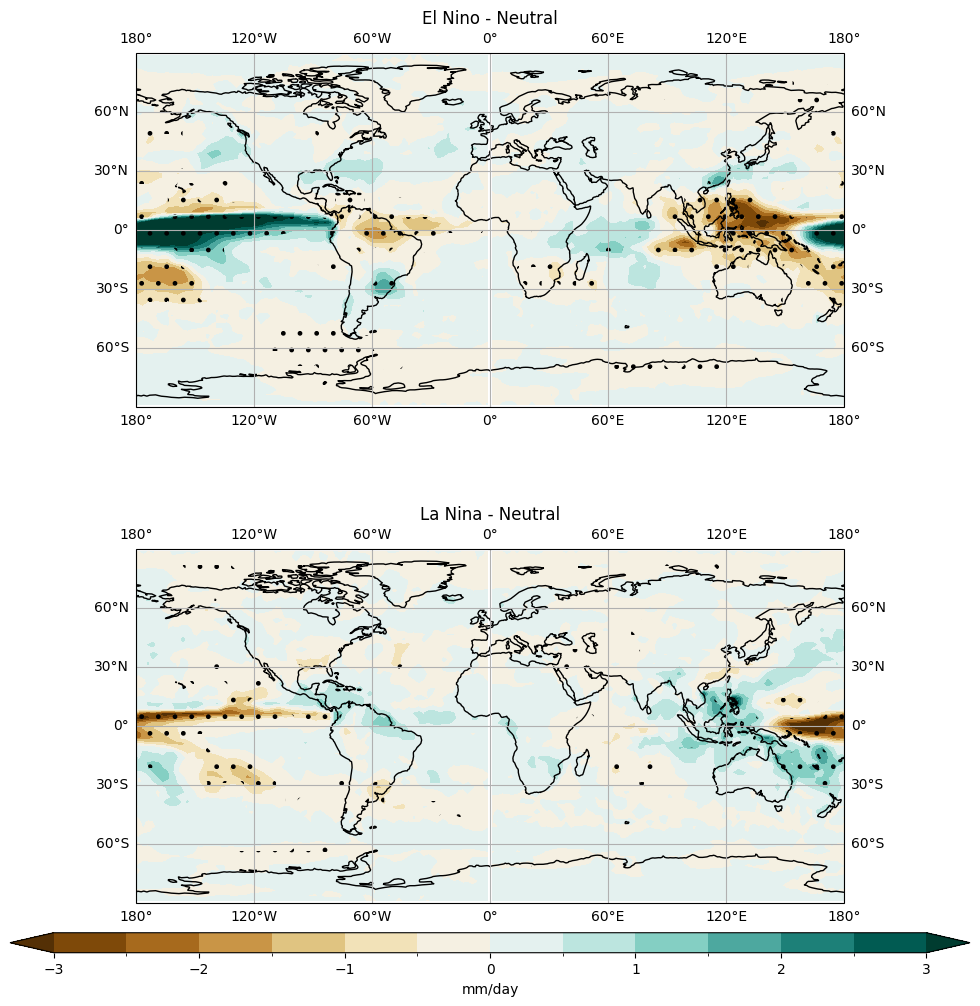

In [32]:
fig = plt.figure(figsize=(12, 10))
projection = ccrs.PlateCarree()

vmin, vmax = -3, 3
titles = [f'El Nino - Neutral', f'La Nina - Neutral']
composites = [elnino_vs_neural, lanina_vs_neural]
ella = [elnino_comp_tt, lanina_comp_tt]

for idx, (title, data) in enumerate(zip(titles, composites)):
    ax = plt.subplot(2, 1, idx + 1, projection=projection)
    
    t_stat, p_value = stats.ttest_ind(ella[idx], neutral_comp_tt, equal_var=False)
    significant_dots = data.where(p_value < 0.05)

    d,lons=add_cyclic_point(data,coord=data['lon'])
    mask_data,lons=add_cyclic_point(significant_dots,coord=data['lon'])

    im = data.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=np.linspace(vmin, vmax, 13),
        cmap='BrBG',
        add_colorbar=False,
        extend='both'
    )

    ax.contourf(lons,data['lat'],mask_data,[0,1],
              transform = ccrs.PlateCarree(),colors='None',
             hatches=['.',''],extend='both',alpha=0)
    
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    ax.set_title(title)
    ax.set_ylim(-90, 90)
    ax.set_xlim(-180, 180)

# Adjust colorbar position
cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.02])
cbar = plt.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('mm/day', fontsize=10)

# Adjust spacing
plt.subplots_adjust(left=0.1, right=0.9, top=0.95, bottom=0.1, hspace=0.4)
plt.show